In [1]:
!pip3 install xgboost
!pip install decision-tree-morfist

In [2]:
import config


import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics
from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [4]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [5]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [6]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

### 檢查缺失值

In [7]:
display(Missing_Counts(data_x))

,ColumnName,MissingCount,Percentage(%)
0,clean_ph4,286,45.04
1,clean_ph5,286,45.04
2,clean_ph7,286,45.04


In [8]:
display(Missing_Counts(data_y))

,ColumnName,MissingCount,Percentage(%)


In [9]:
data_x = data_x.fillna(0)

### 檢查資料屬性

In [10]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_temp,float64
90,painting_g11_act_hvv,float64
89,painting_g11_act_t_air,float64
88,painting_g11_act_f_air,float64
87,painting_g11_act_a_air,float64
86,painting_g10_act_hvc,float64
85,painting_g10_act_hvv,float64
84,painting_g10_act_t_air,float64
83,painting_g10_act_f_air,float64
82,painting_g10_act_a_air,float64


# 1.拆分訓練及測試集

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值

In [29]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    config.Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = Lassocv.alpha_))
                              ])
    
    Lasso_params_list.append({'alpha':Lassocv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # Ridge超參數

    config.Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(alpha = Ridgecv.alpha_))
                              ])
    
    Ridge_params_list.append({'alpha':Ridgecv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # XGBM超參數
    grid_search_xgbm = GridSearchCV(xgb.XGBRegressor(),
                                    param_grid = config.gbm_param_grid,
                                    n_jobs = -1,
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 5)
    grid_search_xgbm.fit(data_x_S, data_y.iloc[:,i])
    params_XGB = grid_search_xgbm.best_params_
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(learning_rate = params_XGB['learning_rate'],
                                                         max_depth = params_XGB['max_depth'],
                                                         n_estimators = params_XGB['n_estimators'],
                                                         min_child_weight = params_XGB['min_child_weight'],
                                                         objective = 'reg:squarederror'))
                            ])
    
    XGB_params_list.append(params_XGB)
    # 訓練模型，計算train, test的RMSE
    

    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # KN超參數
    grid_search_KN = GridSearchCV(KNeighborsRegressor(),
                                  param_grid = config.KN_param_grid,
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error',
                                  cv = 5
                                  )

    grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    params_KN = grid_search_KN.best_params_
    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(n_neighbors = params_KN['n_neighbors'],
                                                    leaf_size = params_KN['leaf_size'],
                                                    weights = params_KN['weights']))
                        ])
    
    KN_params_list.append(params_KN)
    # 訓練模型，計算train, test的RMSE
    
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model
    grid_search_Ada = GridSearchCV(AdaBoostRegressor(),
                               param_grid = config.Ada_param_grid,
                               n_jobs = -1,
                               scoring = 'neg_root_mean_squared_error',
                               cv = 5
                              )
    # grid挑超參數時使用全部資料
    grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])
    params_Ada = grid_search_Ada.best_params_


    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(n_estimators = params_Ada['n_estimators'],
                                                       learning_rate = params_Ada['learning_rate']))
                            ]) 
    
    Ada_params_list.append(params_Ada)
    
    # 訓練模型，計算train, test的RMSE
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        
    
    
# **各模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)    
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    

# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料輸出到Excel檔案
output = pd.ExcelWriter('../Data/output.xlsx')
Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

output.save()

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE
sensor_point5_i_value,{'alpha': 1.0},14.43,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 500}",13.81
sensor_point6_i_value,{'alpha': 5.0},31.02,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.2, 'n_estimators': 300}",28.36
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.5, 'n_estimators': 500}",26.15
sensor_point8_i_value,{'alpha': 5.0},23.64,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.2, 'n_estimators': 500}",22.72
sensor_point9_i_value,{'alpha': 7.0},22.24,{'alpha': 500.0},25.03,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.5, 'n_estimators': 500}",22.12
sensor_point10_i_value,{'alpha': 7.0},17.93,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 500}",17.88


,Actual_sensor_point5_i_value,Lasso_sensor_point5_i_value,Ridge_sensor_point5_i_value,XGB_sensor_point5_i_value,KN_sensor_point5_i_value,Ada_sensor_point5_i_value,Actual_sensor_point6_i_value,Lasso_sensor_point6_i_value,Ridge_sensor_point6_i_value,XGB_sensor_point6_i_value,...,Ridge_sensor_point9_i_value,XGB_sensor_point9_i_value,KN_sensor_point9_i_value,Ada_sensor_point9_i_value,Actual_sensor_point10_i_value,Lasso_sensor_point10_i_value,Ridge_sensor_point10_i_value,XGB_sensor_point10_i_value,KN_sensor_point10_i_value,Ada_sensor_point10_i_value
0,42,50.16,43.96,42.66,46.43,46.50,56,79.82,61.75,55.98,...,69.79,72.43,73.00,71.05,45,88.22,48.61,45.02,45.00,45.33
1,37,50.68,37.28,37.99,40.00,45.69,60,80.59,61.33,61.16,...,67.47,67.28,67.33,71.05,42,88.22,43.19,42.66,42.00,45.33
2,35,50.68,37.28,37.99,40.00,45.69,66,80.59,61.33,61.16,...,67.47,67.28,67.33,71.05,45,88.22,43.19,42.66,42.00,45.33
3,37,50.68,37.28,37.99,40.00,45.69,58,80.59,61.33,61.16,...,67.47,67.28,67.33,71.05,39,88.22,43.19,42.66,42.00,45.33
4,57,51.55,48.31,48.31,46.43,48.40,78,77.56,67.00,70.47,...,60.93,61.22,61.25,70.08,65,88.09,54.25,56.48,58.00,56.57
5,42,51.55,48.31,48.31,46.43,48.40,72,77.56,67.00,70.47,...,60.93,61.22,61.25,70.08,64,88.09,54.25,56.48,58.00,56.57
6,48,51.55,48.31,48.31,46.43,48.40,72,77.56,67.00,70.47,...,60.93,61.22,61.25,70.08,48,88.09,54.25,56.48,58.00,56.57
7,49,51.55,48.31,48.31,46.43,48.40,60,77.56,67.00,70.47,...,60.93,61.22,61.25,70.08,55,88.09,54.25,56.48,58.00,56.57
8,41,52.88,46.70,43.59,46.86,47.12,72,81.52,67.79,70.77,...,64.97,64.30,64.50,70.08,60,88.10,55.85,59.97,60.00,61.00
9,46,52.88,46.70,43.59,46.86,47.12,70,81.52,67.79,70.77,...,64.97,64.30,64.50,70.08,60,88.10,55.85,59.97,60.00,61.00


In [3]:
Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
Model_RMSE.index = [data_y.columns]
Model_RMSE

NameError: name 'data_y' is not defined

In [13]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[['Lasso_RMSE','Ridge_RMSE','XGB_RMSE','KN_RMSE','Ada_RMSE']].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Ada_RMSE
sensor_point6_i_value_best model:XGB_RMSE
sensor_point7_i_value_best model:XGB_RMSE
sensor_point8_i_value_best model:Ada_RMSE
sensor_point9_i_value_best model:KN_RMSE
sensor_point10_i_value_best model:KN_RMSE


In [18]:
import ast

model_name = ['XGB','Ridge','Lasso','Ada','KN']
for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = ast.literal_eval(model_dict[data_y.columns[i]])

    display('model:' + m, 'params:' + str(model_dict))

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 500}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 30}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}}"

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500.0}, 'sensor_point6_i_value': {'alpha': 500.0}, 'sensor_point7_i_value': {'alpha': 100.0}, 'sensor_point8_i_value': {'alpha': 500.0}, 'sensor_point9_i_value': {'alpha': 500.0}, 'sensor_point10_i_value': {'alpha': 500.0}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 1.0}, 'sensor_point6_i_value': {'alpha': 5.0}, 'sensor_point7_i_value': {'alpha': 1.0}, 'sensor_point8_i_value': {'alpha': 5.0}, 'sensor_point9_i_value': {'alpha': 7.0}, 'sensor_point10_i_value': {'alpha': 7.0}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'n_estimators': 500}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'n_estimators': 300}, 'sensor_point7_i_value': {'learning_rate': 0.5, 'n_estimators': 500}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'n_estimators': 500}, 'sensor_point9_i_value': {'learning_rate': 0.5, 'n_estimators': 500}, 'sensor_point10_i_value': {'learning_rate': 0.5, 'n_estimators': 500}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

In [19]:
Model_RMSE.loc[:,m].to_dict()

{('sensor_point5_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}",
 ('sensor_point6_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}",
 ('sensor_point7_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}",
 ('sensor_point8_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}",
 ('sensor_point9_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}",
 ('sensor_point10_i_value',): "{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}"}

# 3.迴圈計算不同排列順序下，平均RMSE結果

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

### 最佳順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [ ]:
def Regression_Chain_Y(order_list, model_list):
    Model_RMSE = []
    RMSE_num = []
    X_PT = data_x
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[order_list[k]]
        model.fit(data_x, data_y.iloc[:,order_list[k]])
        
        # RMSE(train、test)
        Model_RMSE.append(data_y.columns[order_list[k]] + '_RMSE:' + \
                          str(round(-cross_val_score(model, \
                                                     data_x, \
                                                     data_y.iloc[:,order_list[k]], \
                                                     cv = 5, \
                                                     scoring = 'neg_root_mean_squared_error').mean(),2)
                          ))
        
        RMSE_num.append(round(-cross_val_score(model, \
                                                     data_x, \
                                                     data_y.iloc[:,order_list[k]], \
                                                     cv = 5, \
                                                     scoring = 'neg_root_mean_squared_error').mean(),2))
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(data_x)

    # 全部Model RMSE取平均
    RMSE_avg = statistics.mean(RMSE_num)
    return RMSE_avg, Model_RMSE

In [69]:
model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN[data_y.columns[5]]))
                        ])
              ]

RMSE_avg, Model_RMSE = Regression_Chain_Y(config.order_list, model_list)

print('RMSE_avg:' + str(RMSE_avg),'\n\nY_variable_RMSE:' + str(Model_RMSE))

RMSE_avg:21.168333333333333 

Y_variable_RMSE:['sensor_point10_i_value_RMSE:18.03', 'sensor_point8_i_value_RMSE:22.35', 'sensor_point7_i_value_RMSE:25.57', 'sensor_point6_i_value_RMSE:26.41', 'sensor_point9_i_value_RMSE:20.46', 'sensor_point5_i_value_RMSE:13.48']


In [ ]:
# 排列訓練模型，再計算RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_result_list = []
predict_result_avg = []

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada[data_y.columns[0]]))
                        ]),
              
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN[data_y.columns[5]]))
                        ])
              ]

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[list(i)[k]]
        model.fit(data_x, data_y.iloc[:,list(i)[k]])
        
        # RMSE(train、test)
        Model_RMSE.append(-cross_val_score(model, 
                                           data_x, data_y.iloc[:,list(i)[k]], 
                                           cv = 5, 
                                           scoring = 'neg_root_mean_squared_error').mean())
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(data_x)


    order_list.append(''.join(str(list(i))))
    predict_result_avg.append(statistics.mean(Model_RMSE))
    predict_result_list.append(str(Model_RMSE))
    
    print(list(i)) # test 結果
    
    # 取 Model取 train + test後RMSE最低的結果
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_result_avg':predict_result_avg,
                              'predict_result_list':predict_result_list})

display('best model list:' + order_list_fn)
display(Order_result)

# 4.計算實際值跟預測值差異

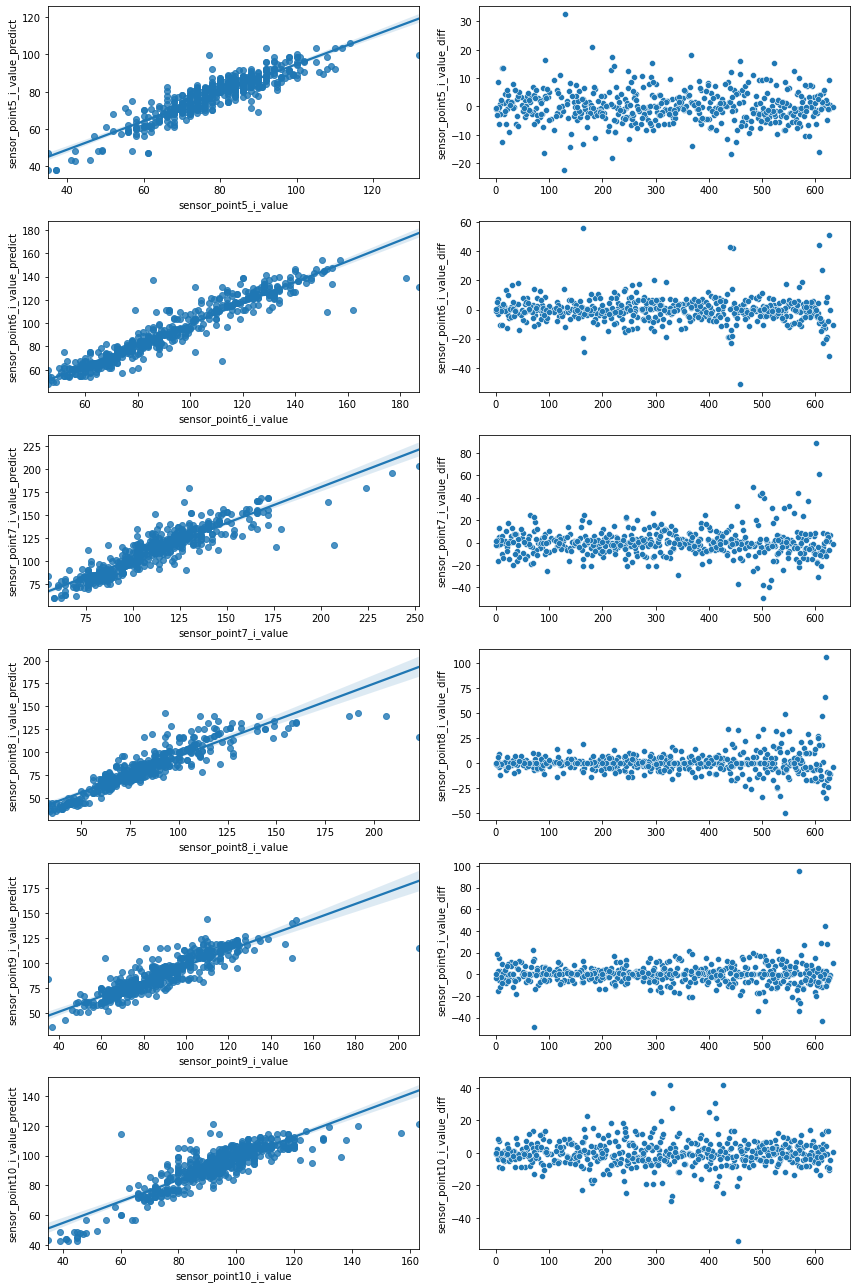

In [31]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_cho = 'XGB' # 選擇 model


Y_predict_diff = Y_train # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_cho + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_cho + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()

# 附件.按步驟測試模型結果

## 1.Lasso + Polymonial
* 不支援多輸出
* 交叉驗證取得最佳超參數
* 訓練模型
* 計算RMSE、R_square

In [ ]:
# RC_poly_Lasso_reg = RegressorChain(base_estimator = poly_Lasso_reg, order = [3,1,2,0,4,5])
# RC_poly_Lasso_reg.fit(X_train, Y_train)

In [23]:
Lassocv =  LassoCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500], cv = 3, max_iter = 10000)
Lassocv.fit(data_x_S, data_y.iloc[:,0])
Lassocv.alpha_

1.0

In [24]:
poly_lasso_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                          ('std_scaler', StandardScaler()),
                          ('ridge_reg', Lasso(alpha = Lassocv.alpha_))
                         ])
poly_lasso_reg.fit(X_train, Y_train.iloc[:,0])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()), ('ridge_reg', Lasso())])

### 訓練結果

In [25]:
Y_predict_train = poly_lasso_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train.iloc[:,0], Y_predict_train)))
print('R_square：',r2_score(Y_train.iloc[:,0], Y_predict_train))

RMSE： 9.911881338197686
R_square： 0.42437813841946503


### 測試結果

In [26]:
Y_predict_test = poly_lasso_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test.iloc[:,0], Y_predict_test)))
print('R_square：',r2_score(Y_test.iloc[:,0], Y_predict_test))

RMSE： 11.409485932815148
R_square： 0.2897642126839255


## 2.Ridge + Polymonial
* 交叉驗證取得最佳超參數
* 訓練模型
* 計算RMSE、R_square

In [30]:
ridgecv = RidgeCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500])
ridgecv.fit(data_x_S, data_y)
ridgecv.alpha_

1.0

In [59]:
poly_ridge_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                          ('std_scaler', StandardScaler()),
                          ('ridge_reg', Ridge(alpha = ridgecv.alpha_))
                         ])
poly_ridge_reg.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()), ('ridge_reg', Ridge())])

### 訓練結果

In [61]:
Y_predict_train = poly_ridge_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, Y_predict_train)))
print('R_square：',r2_score(Y_train, Y_predict_train))

RMSE： 6.0217897150510895
R_square： 0.9387506063249269


### 測試結果

In [63]:
Y_predict_test = poly_ridge_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
print('R_square：',r2_score(Y_test, Y_predict_test))

RMSE： 40.83933505058546
R_square： -2.5251729174874504


## 3.1 XGboosting + Polymonial
* 交叉驗證取得最佳超參數
* 訓練模型
* 計算RMSE、R_square

In [27]:
gbm_param_grid = {'learning_rate':np.array([0.2, 0.5]),
                  'n_estimators':np.array([30, 100, 200, 500]),
                  'max_depth':np.array([3, 5, 9, 13, 20]),
                  'min_child_weight':np.array([1, 3, 10])
                 }

grid_search = GridSearchCV(xgb.XGBRegressor(),
                           param_grid = gbm_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )
# grid挑超參數時使用全部資料
grid_search.fit(data_x_S, data_y)
params = grid_search.best_params_
params

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 30}

In [28]:
poly_xgb_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                          ('std_scaler', StandardScaler()),
                          ('xgb_reg', xgb.XGBRegressor(learning_rate = params['learning_rate'],
                                      max_depth = params['max_depth'],
                                      n_estimators = params['n_estimators'],
                                      min_child_weight = params['min_child_weight'],
                                      objective = 'reg:squarederror'
                                      ))
                         ])
poly_xgb_reg.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('xgb_reg',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.2, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=30, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state

### 訓練結果

In [29]:
Y_predict_train = poly_xgb_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, Y_predict_train)))
print('R_square：',r2_score(Y_train, Y_predict_train))

RMSE： 7.39770586215858
R_square： 0.6890444986775955


### 測試結果

In [30]:
Y_predict_test = poly_xgb_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
print('R_square：',r2_score(Y_test, Y_predict_test))

ValueError: y_true and y_pred have different number of output (6!=18)

In [ ]:
cv_scores = []
#cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
cv = 5
scores = cross_val_score(poly_xgb_reg, data_x, data_y.iloc[:,0], cv = cv, scoring = 'neg_root_mean_squared_error')
cv_scores.append(-scores.mean())
cv_scores

In [ ]:
# 計算實際值跟預測值差異
Y_test_predict_diff = Y_test

for i in range(6):
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_predict'] = Y_predict_test.T[i]
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_diff'] = Y_test[Y_test.columns.tolist()[i]] - Y_predict_test.T[i]
# display(Y_test_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = Y_test.columns.tolist()[i], 
                y = Y_test.columns.tolist()[i] + '_predict', 
                data = Y_test_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x=Y_test_predict_diff.index,
                    y=Y_test.columns.tolist()[i] + '_diff',
                    data = Y_test_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()

### 並非所有回歸算法都支持多輸出回歸(例如：支持向量機SVR)，可以透過MultiOutputRegressor或RegressorChain來達到多輸出回歸的目標，但兩者功能上有些差異：
*1.MultiOutputRegressor：假設輸出彼此獨立，為每個輸出創建提供模型。

*2.RegressorChain：序列中的第一個模型使用輸入並預測一個輸出。第二模型使用第一模型的輸入和輸出進行預測；第三個模型使用前兩個模型的輸入和輸出進行預測，依此類推。(多輸出之間具有順序性，可透過"order"參數指定。例如，order = [0,1]將首先預測第0個輸出，再預測第一個輸出。

## 3.2 XGboosting + Polymonial(RegressorChain)

In [ ]:
check = 1000
order_list = []
predict_train_list = []
predict_test_list =[]

for i in list(permutations(range(6),6)):
    RC_poly_xgb_reg = RegressorChain(base_estimator = poly_xgb_reg, order = list(i))
    RC_poly_xgb_reg.fit(X_train, Y_train)

    order_list.append(''.join(str(i)))
    predict_train_list.append(np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))))
    predict_test_list.append(np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test))))

     # Model取 train + test後RMSE最低的結果
    if np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))) + np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test))) < check:
        check = np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))) + np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test)))
        RC_poly_xgb_reg_fn = RC_poly_xgb_reg

Model_train_result = pd.DataFrame({ 'Group':order_list, 'Train':predict_train_list, 'Test':predict_test_list})
display(Model_train_result)
display(RC_poly_xgb_reg_fn)

### 訓練結果(RegressorChain)

In [ ]:
RC_Y_predict_train = RC_poly_xgb_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, RC_Y_predict_train)))
print('R_square：',r2_score(Y_train, RC_Y_predict_train))

### 測試結果(RegressorChain)

In [ ]:
RC_Y_predict_test = RC_poly_xgb_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, RC_Y_predict_test)))
print('R_square：',r2_score(Y_test, RC_Y_predict_test))

### 比對預測值跟實際值差異

In [ ]:
# 計算實際值跟預測值差異
Y_test_predict_diff = Y_test

for i in range(6):
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_predict'] = RC_Y_predict_test.T[i]
    Y_test_predict_diff[Y_test.columns.tolist()[i] + '_diff'] = Y_test[Y_test.columns.tolist()[i]] - RC_Y_predict_test.T[i]
# display(Y_test_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值
    sns.regplot(x = Y_test.columns.tolist()[i], 
                y = Y_test.columns.tolist()[i] + '_predict', 
                data = Y_test_predict_diff, 
                ax=axes[i, 0])
    
    # 趨勢線
    sns.scatterplot(x=Y_test_predict_diff.index,
                    y=Y_test.columns.tolist()[i] + '_diff',
                    data = Y_test_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()

## 4.KNeighborsRegressor

In [31]:
KN_param_grid = {'n_neighbors':np.array([2, 3, 5, 7]),
                 'leaf_size':np.array([20, 30, 50]),
                 'weights':['uniform','distance']
                }

grid_search = GridSearchCV(KNeighborsRegressor(),
                           param_grid = KN_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )
# grid挑超參數時使用全部資料
grid_search.fit(data_x_S, data_y)

params = grid_search.best_params_
params

{'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}

In [32]:
poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(n_neighbors = params['n_neighbors'],
                                                    leaf_size = params['leaf_size'],
                                                    weights = params['weights']
                                                    ))
                        ])
poly_KN_reg.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('KNR',
                 KNeighborsRegressor(leaf_size=20, n_neighbors=7,
                                     weights='distance'))])

In [33]:
Y_predict_train = poly_KN_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train, Y_predict_train)))
print('R_square：',r2_score(Y_train, Y_predict_train))

RMSE： 8.695394111695832
R_square： 0.8464088924956824


In [34]:
Y_predict_test = poly_KN_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
print('R_square：',r2_score(Y_test, Y_predict_test))

RMSE： 16.899125381116313
R_square： 0.42551414328667203


## 5.AdaBoostRegressor
* 不支援多輸出

In [41]:
ada_param_grid = {'n_estimators':np.array([50, 300, 500]),
                  'learning_rate':np.array([0.2, 0.5]),
                 }

grid_search = GridSearchCV(AdaBoostRegressor(),
                           param_grid = ada_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )
# grid挑超參數時使用全部資料
grid_search.fit(data_x_S, data_y.iloc[:,0])

params = grid_search.best_params_
params

{'learning_rate': 0.2, 'n_estimators': 300}

In [42]:
poly_ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(n_estimators = params['n_estimators'],
                                                  learning_rate = params['learning_rate']
                                                  ))
                        ])
poly_ada_reg.fit(X_train, Y_train.iloc[:,0])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('Ada',
                 AdaBoostRegressor(learning_rate=0.2, n_estimators=300))])

In [45]:
Y_predict_train = poly_ada_reg.predict(X_train)
print('RMSE：',np.sqrt(mean_squared_error(Y_train.iloc[:,0], Y_predict_train)))
print('R_square：',r2_score(Y_train.iloc[:,0], Y_predict_train))

RMSE： 7.799258495254906
R_square： 0.6436049030737079


In [47]:
Y_predict_test = poly_ada_reg.predict(X_test)
print('RMSE：',np.sqrt(mean_squared_error(Y_test.iloc[:,0], Y_predict_test)))
print('R_square：',r2_score(Y_test.iloc[:,0], Y_predict_test))

RMSE： 9.659642470531862
R_square： 0.4909124200114223


### Test：檢查MultiOutputRegressor跑出來的結果跟沒有用MultiOutputRegressor的結果是否有差異

### MixedRandomForest
*n_estimators(int)：森林中的樹木數量。可選的。默認值：10。

*max_features(int | float | str)：尋找最佳分割時要考慮的特徵數量。可選的。默認值：'sqrt'。
如果是 int，則在每次拆分時考慮 max_features 特徵。
如果是浮點數，那麼 max_features 是一個分數，並且在每次拆分時都會考慮 int(max_features * n_features) 個特徵。
如果“sqrt”，則 max_features=sqrt(n_features)（與“auto”相同）。
如果“log2”，則 max_features=log2(n_features)。
如果沒有，那麼 max_features=n_features。
注意：在找到至少一個節點樣本的有效分區之前，對拆分的搜索不會停止，即使它需要有效地檢查超過 max_features 個特徵。

*min_samples_leaf(int)：葉節點所需的最小樣本數。可選的。默認值：5。

注意：任何深度的分割點只有在左右分支中至少留下 min_samples_leaf 訓練樣本時才會被考慮。這可能具有平滑模型的效果，尤其是在回歸中。

*choose_split(str)：用於找到最佳分割的方法。可選的。默認值：“平均值”。

默認情況下，將使用平均信息增益。

可能的值：
'mean'：使用平均信息增益。
'max'：使用最大信息增益。
'random'：隨機選擇其中一個預測任務，並選擇其個體信息增益作為分割的信息增益。
classification_targets(int[])：屬於分類任務的特徵。可選的。默認值：無。

如果未指定分類目標，則隨機森林會將所有變量視為回歸變量。

In [ ]:
wrapper = MultiOutputRegressor(poly_xgb_reg)
wrapper.fit(X_train, Y_train)
Y_predict_MO = wrapper.predict(X_train)
Y_predict_MO - Y_predict

In [ ]:
# check = 1000
# order_list = []
# predict_train_list = []
# predict_test_list =[]
# for a in range(6):
#     for b in range(6):
#         for c in range(6):
#             for d in range(6):
#                 for e in range(6):
#                     for f in range(6):
#                         if a not in set([b,c,d,e,f]) and \
#                            b not in set([c,d,e,f]) and \
#                            c not in set([d,e,f]) and \
#                            d not in set([e,f]) and \
#                            e not in set([f]):
#                             RC_poly_xgb_reg = RegressorChain(base_estimator = poly_xgb_reg, order = [a,b,c,d,e,f])
#                             RC_poly_xgb_reg.fit(X_train, Y_train)
                            
                            
#                             order_list.append(str(a)+str(b)+str(c)+str(d)+str(e)+str(f))
#                             predict_train_list.append(np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))))
#                             predict_test_list.append(np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test))))
                            
#                             # Model取 train + test後RMSE最低的結果
#                             if np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))) \
#                                + np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test))) < check:
#                                 check = np.sqrt(mean_squared_error(Y_train, RC_poly_xgb_reg.predict(X_train))) \
#                                 + np.sqrt(mean_squared_error(Y_test, RC_poly_xgb_reg.predict(X_test)))
#                                 RC_poly_xgb_reg_fn = RC_poly_xgb_reg

# Model_train_result = pd.DataFrame({ 'Group':order_list, 'Train':predict_train_list, 'Test':predict_test_list})
# display(Model_train_result)
# display(RC_poly_xgb_reg_fn)

In [ ]:
# check = 1000
# order_list = []
# predict_train_list = []
# predict_test_list =[]

# for i in list(permutations(range(6),6)):
#     RC_poly_lasso_reg = RegressorChain(base_estimator = [Lasso_model_list[list(i)[0]],
#                                                        Lasso_model_list[list(i)[1]],
#                                                        Lasso_model_list[list(i)[2]],
#                                                        Lasso_model_list[list(i)[3]],
#                                                        Lasso_model_list[list(i)[4]],
#                                                        Lasso_model_list[list(i)[5]]
#                                                        ], order = list(i))
#     RC_poly_lasso_reg.fit(X_train, Y_train)

#     order_list.append(''.join(str(i)))
#     predict_train_list.append(np.sqrt(mean_squared_error(Y_train, RC_poly_lasso_reg.predict(X_train))))
#     predict_test_list.append(np.sqrt(mean_squared_error(Y_test, RC_poly_lasso_reg.predict(X_test))))

#      # Model取 train + test後RMSE最低的結果
#     if np.sqrt(mean_squared_error(Y_train, RC_poly_lasso_reg.predict(X_train))) + np.sqrt(mean_squared_error(Y_test, RC_poly_lasso_reg.predict(X_test))) < check:
#         check = np.sqrt(mean_squared_error(Y_train, RC_poly_lasso_reg.predict(X_train))) + np.sqrt(mean_squared_error(Y_test, RC_poly_lasso_reg.predict(X_test)))
#         RC_poly_lasso_reg_fn = RC_poly_lasso_reg

# Model_train_result = pd.DataFrame({ 'Group':order_list, 'Train':predict_train_list, 'Test':predict_test_list})
# display(Model_train_result)
# display(RC_poly_lasso_reg_fn)

In [ ]:
# Y_predict_test = RC_poly_Lasso_reg.predict(X_test)
# print('RMSE：',np.sqrt(mean_squared_error(Y_test, Y_predict_test)))
# print('R_square：',r2_score(Y_test, Y_predict_test))

In [ ]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_model_list = []
Ridge_model_list = []
XGB_model_list = []
KN_model_list = []
Ada_model_list = []

# 訓練集RMSE
Lasso_train_RMSE = []
Ridge_train_RMSE = []
XGB_train_RMSE = []
KN_train_RMSE = []
Ada_train_RMSE = []

# 測試集RMSE
Lasso_test_RMSE = []
Ridge_test_RMSE = []
XGB_test_RMSE = []
KN_test_RMSE = []
Ada_test_RMSE = []

Model_result_train = pd.DataFrame({})
Model_result_test = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
    Lassocv =  LassoCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500], cv = 3, max_iter = 10000)
    Ridgecv = RidgeCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500], cv = 3)

    gbm_param_grid = {'learning_rate':np.array([0.2]),
                      'n_estimators':np.array([30, 100, 200, 500]),
                      'max_depth':np.array([3, 5, 13, 20]),
                      'min_child_weight':np.array([3, 10])
                      }
    
    KN_param_grid = {'n_neighbors':np.array([2, 3, 5, 7]),
                     'leaf_size':np.array([20, 30, 50]),
                     'weights':['uniform','distance']
                    }
    

# 1. Lasso_model
    Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = Lassocv.alpha_))
                              ])
    
    Lasso_model_list.append(poly_Lasso_reg)
    
    # 訓練模型，計算train, test的RMSE
    poly_Lasso_reg.fit(X_train, Y_train.iloc[:,i])
    Lasso_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_Lasso_reg.predict(X_train))))
    Lasso_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_Lasso_reg.predict(X_test))))

# 2. Ridge_model
    # Ridge超參數

    Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                                                 ('std_scaler', StandardScaler()),
                                                 ('lasso_reg', Ridge(alpha = Ridgecv.alpha_))
                                                ])
    
    Ridge_model_list.append(poly_Ridge_reg)
    
    # 訓練模型，計算train, test的RMSE
    poly_Ridge_reg.fit(X_train, Y_train.iloc[:,i])  
    Ridge_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_Ridge_reg.predict(X_train))))
    Ridge_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_Ridge_reg.predict(X_test))))

# 3. XGB_model
    # XGBM超參數
    grid_search_xgbm = GridSearchCV(xgb.XGBRegressor(),
                                    param_grid = gbm_param_grid,
                                    n_jobs = -1,
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 5)
    grid_search_xgbm.fit(data_x_S, data_y)
    params = grid_search_xgbm.best_params_
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                                               ('std_scaler', StandardScaler()),
                                               ('xgb_reg', xgb.XGBRegressor(learning_rate = params['learning_rate'],
                                                                            max_depth = params['max_depth'],
                                                                            n_estimators = params['n_estimators'],
                                                                            min_child_weight = params['min_child_weight'],
                                                                            objective = 'reg:squarederror')
                                               )
                                              ])
    
    XGB_model_list.append(poly_XGB_reg)
    # 訓練模型，計算train, test的RMSE
    poly_XGB_reg.fit(X_train, Y_train.iloc[:,i])  
    XGB_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_XGB_reg.predict(X_train))))
    XGB_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_XGB_reg.predict(X_test))))


# 4. KN_model
    # KN超參數
    grid_search_KN = GridSearchCV(KNeighborsRegressor(),
                           param_grid = KN_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )

    grid_search_KN.fit(data_x_S, data_y)

    params = grid_search_KN.best_params_
    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(n_neighbors = params['n_neighbors'],
                                                    leaf_size = params['leaf_size'],
                                                    weights = params['weights']
                                                    ))
                        ])
    
    KN_model_list.append(poly_KN_reg)
    # 訓練模型，計算train, test的RMSE
    poly_KN_reg.fit(X_train, Y_train.iloc[:,i])  
    KN_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_KN_reg.predict(X_train))))
    KN_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_KN_reg.predict(X_test))))


    
    
# **各模型預測結果放入Model_result
    Model_result_train['Actual_'+ data_y.columns.tolist()[i]] = Y_train.iloc[:,i]
    Model_result_test['Actual_'+ data_y.columns.tolist()[i]] = Y_test.iloc[:,i]
    Model_result_train['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(X_train)
    Model_result_test['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(X_test)
    Model_result_train['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(X_train)
    Model_result_test['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(X_test)
    Model_result_train['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(X_train)
    Model_result_test['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(X_test)    
    Model_result_train['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(X_train)
    Model_result_test['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(X_test)       

# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_model_list,
                           'Lasso_train':Lasso_train_RMSE,
                           'Lasso_test':Lasso_test_RMSE,
                           'Ridge':Ridge_model_list,
                           'Ridge_train':Ridge_train_RMSE,
                           'Ridge_test':Ridge_test_RMSE,
                           'XGB':XGB_model_list,
                           'XGB_train':XGB_train_RMSE,
                           'XGB_test':XGB_test_RMSE,
                           'KN':KN_model_list,
                           'KN_train':KN_train_RMSE,
                           'KN_test':KN_test_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result_train)
display(Model_result_test)

In [ ]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []

# 訓練集RMSE
Lasso_train_RMSE = []
Ridge_train_RMSE = []
XGB_train_RMSE = []
KN_train_RMSE = []
Ada_train_RMSE = []

# 測試集RMSE
Lasso_test_RMSE = []
Ridge_test_RMSE = []
XGB_test_RMSE = []
KN_test_RMSE = []
Ada_test_RMSE = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []

Model_result_train = pd.DataFrame({})
Model_result_test = pd.DataFrame({})
Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
    Lassocv =  LassoCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500], cv = 3, max_iter = 10000)
    Ridgecv = RidgeCV(alphas = [0.01,0.1,0.5,1,5,7,10,30,100,500], cv = 3)

    gbm_param_grid = {'learning_rate':np.array([0.2]),
                      'n_estimators':np.array([30, 100, 200, 500]),
                      'max_depth':np.array([3, 5, 13, 20]),
                      'min_child_weight':np.array([3, 10])
                      }
    
    KN_param_grid = {'n_neighbors':np.array([2, 3, 5, 7]),
                     'leaf_size':np.array([20, 30, 50]),
                     'weights':['uniform','distance']
                    }
    
    Ada_param_grid = {'n_estimators':np.array([50, 300, 500]),
                      'learning_rate':np.array([0.2, 0.5]),
                     }
    

# 1. Lasso_model
    Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = Lassocv.alpha_))
                              ])
    
    Lasso_params_list.append({'alpha':Lassocv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Lasso_RMSE.append(cross_val_score(poly_Lasso_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error'))
    
    
    
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    
#     poly_Lasso_reg.fit(X_train, Y_train.iloc[:,i])
    
#     Lasso_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_Lasso_reg.predict(X_train))))
#     Lasso_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_Lasso_reg.predict(X_test))))

# 2. Ridge_model
    # Ridge超參數

    Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(alpha = Ridgecv.alpha_))
                               ])
    
    Ridge_params_list.append({'alpha':Ridgecv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Ridge_RMSE.append(cross_val_score(poly_Ridge_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error'))
    
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])
    
#     poly_Ridge_reg.fit(X_train, Y_train.iloc[:,i])  
#     Ridge_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_Ridge_reg.predict(X_train))))
#     Ridge_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_Ridge_reg.predict(X_test))))

# 3. XGB_model
    # XGBM超參數
    grid_search_xgbm = GridSearchCV(xgb.XGBRegressor(),
                                    param_grid = gbm_param_grid,
                                    n_jobs = -1,
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 5)
    grid_search_xgbm.fit(data_x_S, data_y.iloc[:,i])
    params_XGB = grid_search_xgbm.best_params_
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                                               ('std_scaler', StandardScaler()),
                                               ('xgb_reg', xgb.XGBRegressor(learning_rate = params_XGB['learning_rate'],
                                                                            max_depth = params_XGB['max_depth'],
                                                                            n_estimators = params_XGB['n_estimators'],
                                                                            min_child_weight = params_XGB['min_child_weight'],
                                                                            objective = 'reg:squarederror')
                                               )
                                              ])
    
    XGB_params_list.append(params_XGB)
    # 訓練模型，計算train, test的RMSE
    

    XGB_RMSE.append(cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error'))
    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])
    
    
#     poly_XGB_reg.fit(X_train, Y_train.iloc[:,i])  
#     XGB_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_XGB_reg.predict(X_train))))
#     XGB_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_XGB_reg.predict(X_test))))


# 4. KN_model
    # KN超參數
    grid_search_KN = GridSearchCV(KNeighborsRegressor(),
                           param_grid = KN_param_grid,
                           n_jobs = -1,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5
                          )

    grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    params_KN = grid_search_KN.best_params_
    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(n_neighbors = params_KN['n_neighbors'],
                                                    leaf_size = params_KN['leaf_size'],
                                                    weights = params_KN['weights']
                                                    ))
                        ])
    
    KN_params_list.append(params_KN)
    # 訓練模型，計算train, test的RMSE
    
    KN_RMSE.append(cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error'))
    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    
    
    
    
#     poly_KN_reg.fit(X_train, Y_train.iloc[:,i])  
#     KN_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_KN_reg.predict(X_train))))
#     KN_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_KN_reg.predict(X_test))))

# 5. Ada_model
    grid_search_Ada = GridSearchCV(AdaBoostRegressor(),
                               param_grid = Ada_param_grid,
                               n_jobs = -1,
                               scoring = 'neg_root_mean_squared_error',
                               cv = 5
                              )
    # grid挑超參數時使用全部資料
    grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])
    params_Ada = grid_search.best_params_


    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(n_estimators = params_Ada['n_estimators'],
                                                       learning_rate = params_Ada['learning_rate']
                                                       ))
                            ]) 
    
    Ada_params_list.append(params_Ada)
    
    # 訓練模型，計算train, test的RMSE
    Ada_RMSE.append(cross_val_score(poly_Ada_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error'))
    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        
    
    
    
#     poly_Ada_reg.fit(X_train, Y_train.iloc[:,i])
#     Ada_train_RMSE.append(np.sqrt(mean_squared_error(Y_train.iloc[:,i], poly_Ada_reg.predict(X_train))))
#     Ada_test_RMSE.append(np.sqrt(mean_squared_error(Y_test.iloc[:,i], poly_Ada_reg.predict(X_test))))
    
    
# **各模型預測結果放入Model_result
    
    Model_result['Actual'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)    
    Model_result['Ada'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    
    
#     Model_result_train['Actual'+ data_y.columns.tolist()[i]] = Y_train.iloc[:,i]
#     Model_result_test['Actual'+ data_y.columns.tolist()[i]] = Y_test.iloc[:,i]
#     Model_result_train['Lasso'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(X_train)
#     Model_result_test['Lasso'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(X_test)
#     Model_result_train['Ridge'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(X_train)
#     Model_result_test['Ridge'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(X_test)
#     Model_result_train['XGB'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(X_train)
#     Model_result_test['XGB'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(X_test)    
#     Model_result_train['KN'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(X_train)
#     Model_result_test['KN'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(X_test)       

# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
#                            'Lasso_train':Lasso_train_RMSE,
#                            'Lasso_test':Lasso_test_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
#                            'Ridge_train':Ridge_train_RMSE,
#                            'Ridge_test':Ridge_test_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
#                            'XGB_train':XGB_train_RMSE,
#                            'XGB_test':XGB_test_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
#                            'KN_train':KN_train_RMSE,
#                            'KN_test':KN_test_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE
#                            'Ada_train':Ada_train_RMSE,
#                            'Ada_test':Ada_test_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)
# display(Model_result_train)
# display(Model_result_test)

In [21]:
# 排列訓練模型，再計算測試、訓練集RMSE平均數。最佳排列結果取測試集及訓練集RMSE合計最小

check = 1000
order_list = []
predict_train_list = []
predict_test_list =[]
predict_train_avg = []
predict_test_avg = []

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    train_rl = []
    test_rl = []
    X_train_PT = X_train
    X_test_PT = X_test
    
    for k in range(6):
        # 按照排列順序訓練模型
        poly_lasso_reg = Lasso_model_list[list(i)[k]]
        poly_lasso_reg.fit(X_train, Y_train.iloc[:,list(i)[k]])
        
        # lasso RMSE(train、test)
        train_rl.append(np.sqrt(mean_squared_error(Y_train.iloc[:,list(i)[k]], poly_lasso_reg.predict(X_train_PT))))
        test_rl.append(np.sqrt(mean_squared_error(Y_test.iloc[:,list(i)[k]], poly_lasso_reg.predict(X_test_PT))))
        
        # 把取得的預測值當作變數放進X(train, test)
        X_train_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = poly_lasso_reg.predict(X_train_PT)
        X_test_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = poly_lasso_reg.predict(X_test_PT)  


    order_list.append(''.join(str(list(i))))
    predict_train_avg.append(statistics.mean(train_rl))
    predict_test_avg.append(statistics.mean(test_rl))
    predict_train_list.append(str(train_rl))
    predict_test_list.append(str(test_rl))
    
    # 取 Model取 train + test後RMSE最低的結果
    if (statistics.mean(train_rl) + statistics.mean(test_rl))/2 < check:
        check = (statistics.mean(train_rl) + statistics.mean(test_rl))/2
        order_list_fn = str(list(i))


Model_train_result = pd.DataFrame({ 'Group':order_list,
                                    'Train_avg':predict_train_avg,
                                    'Test_avg':predict_test_avg,
                                    'Train_list':predict_train_list, 
                                    'Test_list':predict_test_list})

display(Model_train_result)
display(order_list_fn)

,Group,Train_avg,Test_avg,Train_list,Test_list
0,"[0, 1, 2, 3, 4, 5]",16.78,18.40,"[7.9744296848850125, 16.588704198641835, 22.26...","[11.169628927523748, 23.29730388559398, 22.709..."
1,"[0, 1, 2, 3, 5, 4]",16.82,18.44,"[7.974429684885013, 16.588704198641835, 22.264...","[11.169628927523748, 23.297303885593983, 22.70..."
2,"[0, 1, 2, 4, 3, 5]",16.75,18.36,"[7.974429675262273, 16.588704198631177, 22.264...","[11.16962890394919, 23.297303885565533, 22.709..."
3,"[0, 1, 2, 4, 5, 3]",16.70,18.31,"[7.974429613799821, 16.588704198563118, 22.264...","[11.169628753373408, 23.297303885383805, 22.70..."
4,"[0, 1, 2, 5, 3, 4]",16.81,18.42,"[7.974428910957102, 16.58870419778482, 22.2646...","[11.169627031482397, 23.297303883305712, 22.70..."
5,"[0, 1, 2, 5, 4, 3]",16.79,18.36,"[7.97442962744775, 16.588704198578235, 22.2646...","[11.169628786809241, 23.29730388542416, 22.709..."
6,"[0, 1, 3, 2, 4, 5]",16.69,18.45,"[7.974428912443557, 16.58870419778647, 17.6932...","[11.16962703512418, 23.297303883310107, 18.431..."
7,"[0, 1, 3, 2, 5, 4]",16.76,18.50,"[7.974429632194992, 16.588704198583493, 17.693...","[11.1696287984394, 23.297303885438197, 18.4311..."
8,"[0, 1, 3, 4, 2, 5]",16.78,18.55,"[7.974429684885013, 16.588704198641835, 17.693...","[11.169628927523748, 23.297303885593983, 18.43..."
9,"[0, 1, 3, 4, 5, 2]",16.75,18.48,"[7.974429685376893, 16.58870419864238, 17.6932...","[11.169628928728807, 23.297303885595436, 18.43..."


'[5, 3, 2, 1, 4, 0]'

### K-fold驗算是否過擬
*n_spilits 折數; n_repeats 交叉驗證器需要重複的次數

In [ ]:
cv_scores = []
#cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
cv = 5
scores = cross_val_score(RC_poly_xgb_reg, data_x, data_y, cv = cv, scoring = 'neg_root_mean_squared_error')
cv_scores.append(-scores.mean())
cv_scores

In [ ]:
scores = cross_val_score(RC_poly_xgb_reg, 
                         data_x, data_y, 
                         cv = 5, 
                         scoring = 'neg_root_mean_squared_error')